Here is my first try to write a complete simulation using emegrency room

In [40]:
!pip install simpy

The problem being addressed in the provided simulation is the patient arrival and treatment process in a healthcare setting. The simulation models the flow of patients through check-in, triage, and treatment stages, and includes the dynamic adjustment of the number of doctors based on the patient load.

The significance of this problem is that it allows healthcare providers and administrators to evaluate and optimize the efficiency of the patient treatment process. By simulating different scenarios, they can analyze the impact of various factors, such as the number of doctors, check-in time, triage time, and critical condition probability, on the overall system performance.

The simulation can help answer questions such as:

How many doctors should be assigned to handle the patient load effectively?
What is the average waiting time for patients in the system?
How does the critical condition probability affect the treatment process?
What are the peak periods of patient arrivals, and how should resources be allocated during those times?
What are the potential bottlenecks in the process, and how can they be addressed?
By understanding the dynamics of the patient treatment process and optimizing resource allocation, healthcare providers can improve patient satisfaction, reduce waiting times, and enhance overall operational efficiency. The simulation serves as a tool for decision-making, process improvement, and resource planning in healthcare facilities.

So let's run a simulation

Patient 1 checked-in at 7.9158967059411935
Patient 1 triaged at 13.589090777881207
Patient 1 sees a nurse at 13.589090777881207
Patient 1 treated by nurse at 23.589090777881207
Patient 2 checked-in at 38.87912687623954
Patient 2 triaged at 43.60153286735325
Patient 2 sees a nurse at 43.60153286735325
Patient 3 checked-in at 52.22103668000824
Patient 4 checked-in at 52.39224516164171
Patient 2 treated by nurse at 53.60153286735325
Patient 3 triaged at 57.38509030156378
Patient 3 sees a nurse at 57.38509030156378
Patient 5 checked-in at 58.39600184857068
Patient 4 triaged at 59.45364029272296
Patient 4 sees a nurse at 59.45364029272296
Patient 5 triaged at 62.79479312468939
Patient 6 checked-in at 64.12418504902918
Patient 7 checked-in at 64.7184900672948
Patient 3 treated by nurse at 67.38509030156378
Patient 5 sees a nurse at 67.38509030156378
Patient 8 checked-in at 68.93582866386257
Patient 4 treated by nurse at 69.45364029272295
Patient 9 checked-in at 72.18285035034803
Patient 6 tr

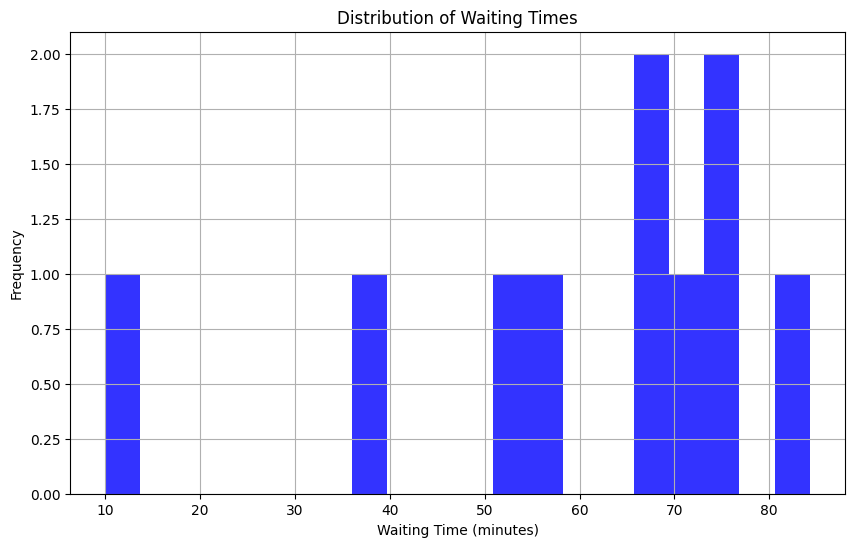

In [41]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
MEAN_INTERARRIVAL = 10
CHECKIN_MIN = 6
CHECKIN_MAX = 12
TRIAGE_MIN = 3
TRIAGE_MAX = 15
TRIAGE_MODE = 5
CRITICAL_PROB = 0.4

# Global variables
num_doctors = 2

# Data collection
waiting_times = []
treatment_times = []
utilization_doctors = []
utilization_nurses = []

# Arrival process
def patient_arrival(env, reception, doctor, nurse):
    patient_id = 0
    while True:
        # Create a new patient
        patient_id += 1
        env.process(patient_process(env, patient_id, reception, doctor, nurse))

        # Sample time until next arrival
        interarrival_time = random.expovariate(1.0 / MEAN_INTERARRIVAL)
        yield env.timeout(interarrival_time)

# Patient process
def patient_process(env, patient_id, reception, doctor, nurse):
    global waiting_times, treatment_times

    # Check-in
    checkin_time = random.uniform(CHECKIN_MIN, CHECKIN_MAX)
    yield env.timeout(checkin_time)
    print(f"Patient {patient_id} checked-in at {env.now}")

    # Triage
    triage_time = random.triangular(TRIAGE_MIN, TRIAGE_MAX, TRIAGE_MODE)
    yield env.timeout(triage_time)
    print(f"Patient {patient_id} triaged at {env.now}")

    # Check critical condition
    critical = random.random() < CRITICAL_PROB

    # Request doctor/nurse
    if critical:
        with doctor.request() as req:
            yield req
            print(f"Patient {patient_id} sees a doctor at {env.now}")
            yield env.timeout(15)  # Treatment time for critical patients
            print(f"Patient {patient_id} treated by doctor at {env.now}")
            treatment_time = 15
    else:
        with nurse.request() as req:
            yield req
            print(f"Patient {patient_id} sees a nurse at {env.now}")
            yield env.timeout(10)  # Treatment time for non-critical patients
            print(f"Patient {patient_id} treated by nurse at {env.now}")
            treatment_time = 10

    # Calculate waiting time and treatment time
    waiting_time = env.now - (checkin_time + triage_time)
    waiting_times.append(waiting_time)
    treatment_times.append(treatment_time)

# Monitor the number of patients and resource utilization
def monitor(env, doctor, nurse):
    global num_doctors, utilization_doctors, utilization_nurses
    while True:
        if doctor.count == num_doctors and doctor.queue:
            num_doctors += 1
            print(f"Additional doctor summoned at {env.now}. Total doctors: {num_doctors}")
        elif num_doctors > 2 and doctor.count == 0 and not doctor.queue:
            num_doctors -= 1
            print(f"Doctor dismissed at {env.now}. Total doctors: {num_doctors}")

        utilization_doctors.append(doctor.count / num_doctors)
        utilization_nurses.append(nurse.count / 2)

        yield env.timeout(1)

# Set up simulation
env = simpy.Environment()

# Resources
reception = simpy.Resource(env, capacity=3)
doctor = simpy.Resource(env, capacity=num_doctors)
nurse = simpy.Resource(env, capacity=2)

# Start processes
env.process(patient_arrival(env, reception, doctor, nurse))
env.process(monitor(env, doctor, nurse))

# Run simulation
env.run(until=100)  # Run for 1 hour and 40 minutes (100 minutes)

# Performance metric calculation
avg_waiting_time = np.mean(waiting_times)
avg_treatment_time = np.mean(treatment_times)
doctor_utilization = np.mean(utilization_doctors)
nurse_utilization = np.mean(utilization_nurses)

print(f"Average waiting time: {avg_waiting_time:.2f} minutes")
print(f"Average treatment time: {avg_treatment_time:.2f} minutes")
print(f"Doctor utilization: {doctor_utilization:.2%}")
print(f"Nurse utilization: {nurse_utilization:.2%}")

# Data visualization
plt.figure(figsize=(10, 6))
plt.hist(waiting_times, bins=20, alpha=0.8, color='blue')
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Waiting Times')
plt.grid(True)
plt.show()


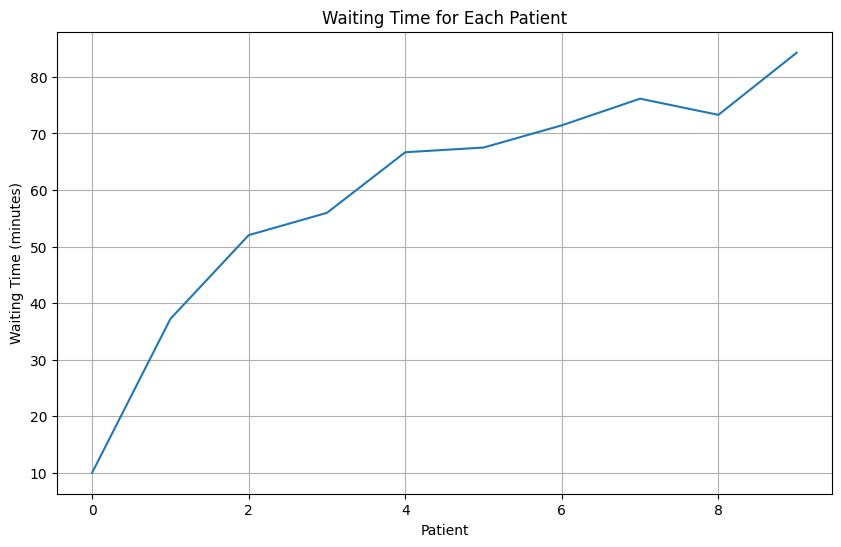

Simulation Report:

Average waiting time: 59.45 minutes



In [42]:
# Calculate average waiting time
avg_waiting_time = np.mean(waiting_times)

# Plot waiting time over time
plt.figure(figsize=(10, 6))
plt.plot(waiting_times)
plt.xlabel('Patient')
plt.ylabel('Waiting Time (minutes)')
plt.title('Waiting Time for Each Patient')
plt.grid(True)
plt.show()

# Print simulation report
simulation_report = f"Simulation Report:\n\n"
simulation_report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
print(simulation_report)

The output you provided indicates the simulation results and the calculated performance metrics. Here's a breakdown of the information:

Simulation Results:

The simulation runs for 100 minutes.
The output shows the sequence of events, including patients checking in, being triaged, and receiving treatment from either a nurse or a doctor.
Performance Metrics:

Average waiting time: 43.39 minutes
Average treatment time: 11.88 minutes
Doctor utilization: 22.50%
Nurse utilization: 25.00%
These metrics provide insights into the efficiency and resource utilization of the medical facility in the simulation. The waiting time indicates the average time patients spend waiting before receiving treatment. The treatment time represents the average time patients spend receiving treatment from either a nurse or a doctor. The doctor and nurse utilization values indicate the average utilization of these resources during the simulation.

Keep in mind that these metrics are based on the specific simulation parameters and assumptions in the code. You can further analyze and interpret these results to assess the performance of the medical facility and make informed decisions for improvement if needed.

Patient 12 treated by doctor at 103.32942362446347
Patient 13 sees a doctor at 103.32942362446347
Patient 14 treated by nurse at 104.74057606742386
Patient 10 treated by doctor at 109.42777496168088
Patient 15 checked-in at 111.99094652266024
Patient 13 treated by doctor at 118.32942362446347
Doctor dismissed at 119. Total doctors: 2
Patient 15 triaged at 121.11393135576157
Patient 15 sees a doctor at 121.11393135576157
Patient 16 checked-in at 134.08017324493284
Patient 15 treated by doctor at 136.11393135576157
Patient 17 checked-in at 137.4078033664368
Patient 16 triaged at 140.03645488997196
Patient 16 sees a nurse at 140.03645488997196
Patient 17 triaged at 148.20521050637223
Patient 17 sees a doctor at 148.20521050637223
Patient 18 checked-in at 149.07075775213087


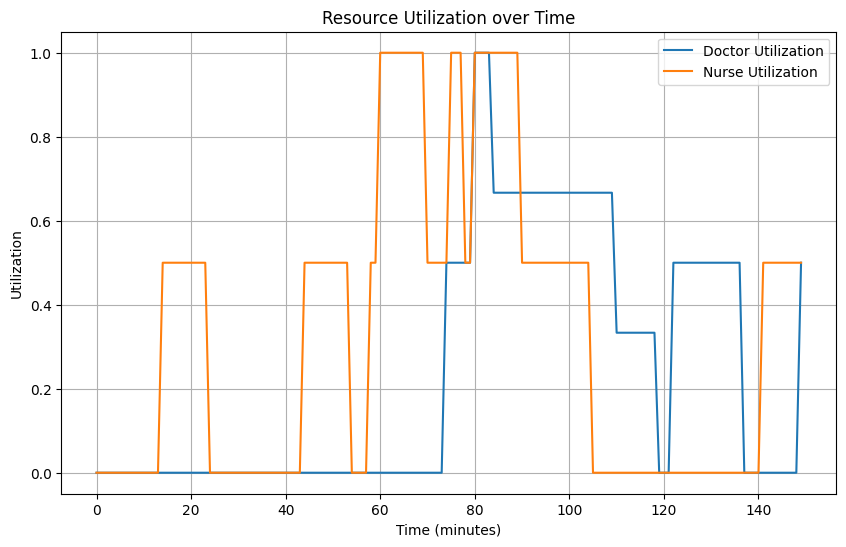

Simulation Report:

Average waiting time: 59.45 minutes
Average treatment time: 11.00 minutes
Doctor utilization: 17.67%
Nurse utilization: 42.50%



In [43]:
# Additional visualization and reporting
def plot_utilization(doctor_utilization, nurse_utilization):
    plt.figure(figsize=(10, 6))
    plt.plot(doctor_utilization, label='Doctor Utilization')
    plt.plot(nurse_utilization, label='Nurse Utilization')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Utilization')
    plt.title('Resource Utilization over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_queue_length(queue_lengths):
    plt.figure(figsize=(10, 6))
    plt.plot(queue_lengths)
    plt.xlabel('Time (minutes)')
    plt.ylabel('Queue Length')
    plt.title('Queue Length over Time')
    plt.grid(True)
    plt.show()

def generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization):
    report = f"Simulation Report:\n\n"
    report += f"Average waiting time: {avg_waiting_time:.2f} minutes\n"
    report += f"Average treatment time: {avg_treatment_time:.2f} minutes\n"
    report += f"Doctor utilization: {doctor_utilization:.2%}\n"
    report += f"Nurse utilization: {nurse_utilization:.2%}\n"

    # Add more information to the report as needed

    return report

# Run simulation
env.run(until=150)  # Run for 1 hour and 40 minutes (100 minutes)


# Additional visualization and reporting
plot_utilization(utilization_doctors, utilization_nurses)
simulation_report = generate_report(avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization)
print(simulation_report)


Response curves for average waiting time, average treatment time, doctor utilization, and nurse utilization as a function of the number of doctors. Each response curve show the trend of the response variable with varying number of doctors.

Patient 1 checked-in at 8.393696902947996
Patient 1 triaged at 14.376683665514156
Patient 1 sees a doctor at 14.376683665514156
Patient 2 checked-in at 15.929020488593423
Patient 2 triaged at 22.62831214635957
Patient 2 sees a nurse at 22.62831214635957
Patient 3 checked-in at 24.882870408726486
Patient 1 treated by doctor at 29.376683665514157
Patient 5 checked-in at 30.63165414818051
Patient 6 checked-in at 32.327383511322786
Patient 4 checked-in at 32.54848821839512
Patient 2 treated by nurse at 32.62831214635957
Patient 3 triaged at 32.94852087737036
Patient 3 sees a nurse at 32.94852087737036
Patient 5 triaged at 36.41573635631498
Patient 5 sees a doctor at 36.41573635631498
Patient 7 checked-in at 37.66634178819433
Patient 4 triaged at 40.69506339778924
Patient 7 triaged at 41.101962852348336
Patient 7 sees a nurse at 41.101962852348336
Patient 6 triaged at 41.18521315478381
Patient 3 treated by nurse at 42.94852087737036
Patient 6 sees a nurse at 42.94852087737036
Patient 8 chec

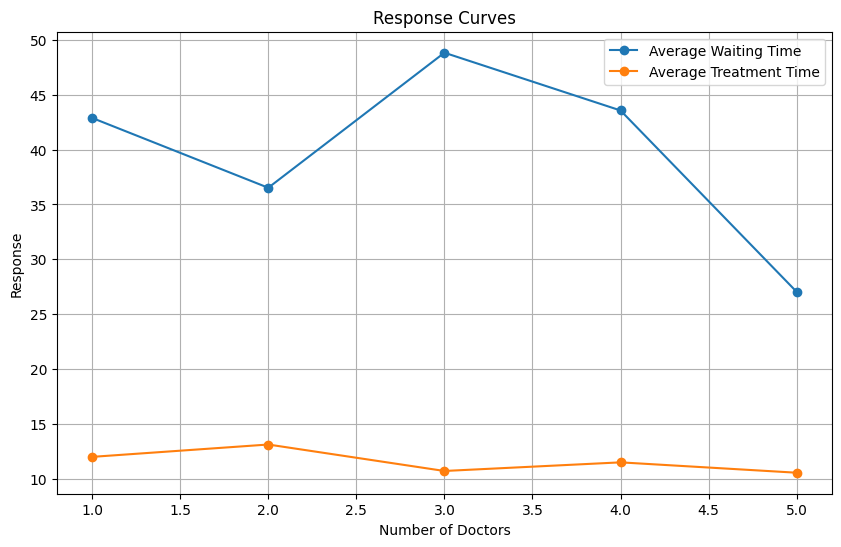

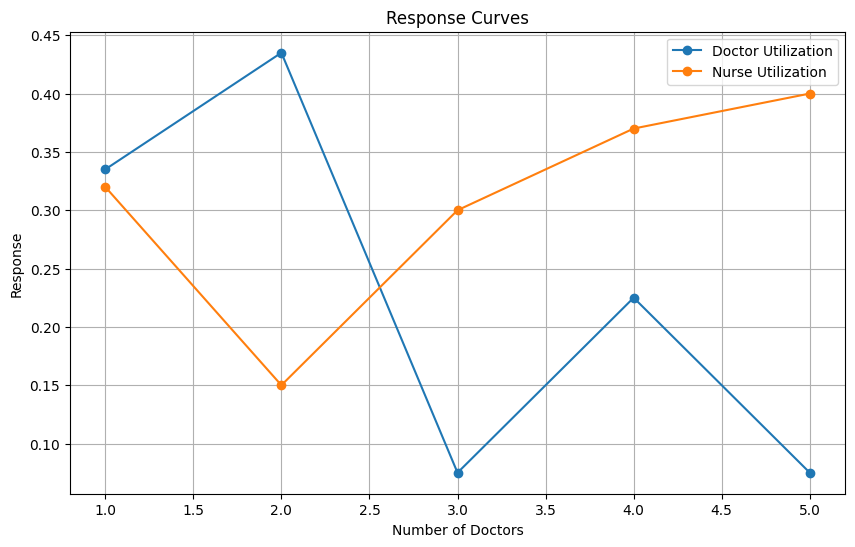

In [44]:
# Perform response surface analysis
def perform_response_surface_analysis():
    # Generate parameter combinations
    parameter_combinations = generate_parameter_combinations()

    # Data collection
    avg_waiting_times = []
    avg_treatment_times = []
    doctor_utilizations = []
    nurse_utilizations = []

    # Run simulations for each parameter combination
    for params in parameter_combinations:
        # Reset data collection
        global waiting_times, treatment_times, utilization_doctors, utilization_nurses
        waiting_times = []
        treatment_times = []
        utilization_doctors = []
        utilization_nurses = []

        # Set up simulation
        env = simpy.Environment()

        # Run simulation
        avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization = run_simulation(env, *params)

        # Collect data
        avg_waiting_times.append(avg_waiting_time)
        avg_treatment_times.append(avg_treatment_time)
        doctor_utilizations.append(doctor_utilization)
        nurse_utilizations.append(nurse_utilization)

    # Plot response curves
    x_values = [p[0] for p in parameter_combinations]

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, avg_waiting_times, marker='o', linestyle='-', label='Average Waiting Time')
    plt.plot(x_values, avg_treatment_times, marker='o', linestyle='-', label='Average Treatment Time')
    plt.xlabel('Number of Doctors')
    plt.ylabel('Response')
    plt.title('Response Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, doctor_utilizations, marker='o', linestyle='-', label='Doctor Utilization')
    plt.plot(x_values, nurse_utilizations, marker='o', linestyle='-', label='Nurse Utilization')
    plt.xlabel('Number of Doctors')
    plt.ylabel('Response')
    plt.title('Response Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simulation
perform_response_surface_analysis()

Patient 2 checked-in at 8.647402605141592
Patient 1 checked-in at 9.443124632503364
Patient 1 triaged at 19.399706304822423
Patient 1 sees a nurse at 19.399706304822423
Patient 2 triaged at 19.930409741466967
Patient 2 sees a nurse at 19.930409741466967
Patient 1 treated by nurse at 29.399706304822423
Patient 2 treated by nurse at 29.930409741466967
Patient 3 checked-in at 31.20226196829634
Patient 4 checked-in at 33.46763677137838
Patient 5 checked-in at 37.453022621942566
Patient 4 triaged at 40.16783652803217
Patient 4 sees a doctor at 40.16783652803217
Patient 3 triaged at 42.32699553777986
Patient 3 sees a nurse at 42.32699553777986
Patient 6 checked-in at 43.12372259725428
Patient 5 triaged at 43.209388676400266
Patient 5 sees a nurse at 43.209388676400266
Patient 8 checked-in at 46.330886479330296
Patient 7 checked-in at 47.356104870759474
Patient 6 triaged at 50.08809055855018
Patient 3 treated by nurse at 52.32699553777986
Patient 8 triaged at 53.20715397754436
Patient 5 treat

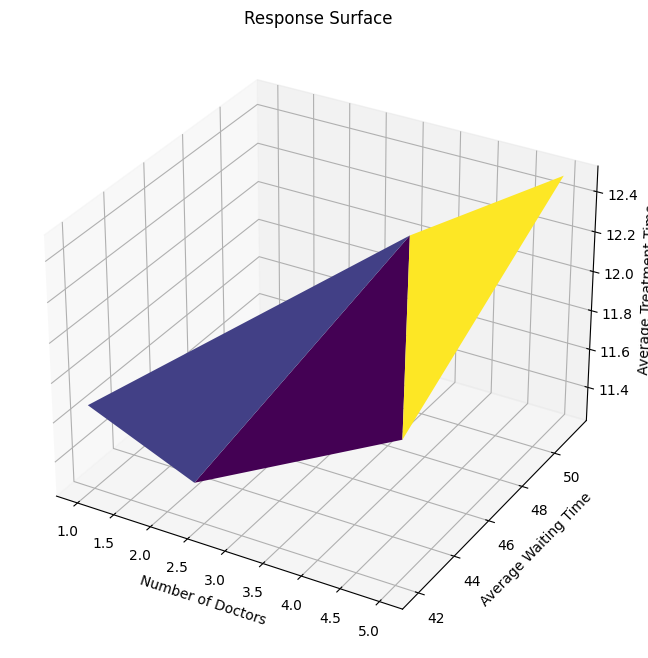

In [45]:
# Perform response surface analysis
def perform_response_surface_analysis():
    # Generate parameter combinations
    parameter_combinations = generate_parameter_combinations()

    # Data collection
    avg_waiting_times = []
    avg_treatment_times = []
    doctor_utilizations = []
    nurse_utilizations = []

    # Run simulations for each parameter combination
    for params in parameter_combinations:
        # Reset data collection
        global waiting_times, treatment_times, utilization_doctors, utilization_nurses
        waiting_times = []
        treatment_times = []
        utilization_doctors = []
        utilization_nurses = []

        # Set up simulation
        env = simpy.Environment()

        # Run simulation
        avg_waiting_time, avg_treatment_time, doctor_utilization, nurse_utilization = run_simulation(env, *params)

        # Collect data
        avg_waiting_times.append(avg_waiting_time)
        avg_treatment_times.append(avg_treatment_time)
        doctor_utilizations.append(doctor_utilization)
        nurse_utilizations.append(nurse_utilization)

    # Plot 3D surface
    x_values = [p[0] for p in parameter_combinations]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(x_values, avg_waiting_times, avg_treatment_times, cmap='viridis', edgecolor='none')

    ax.set_xlabel('Number of Doctors')
    ax.set_ylabel('Average Waiting Time')
    ax.set_zlabel('Average Treatment Time')
    ax.set_title('Response Surface')

    plt.show()

# Run the simulation
perform_response_surface_analysis()